# [모듈 3.1] MAB A/B Testing 시뮬레이션
- MAB (Multi-Armed Bandits)

---

# 1. 환경 셋업

In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
%store -r
%store

Stored variables and their in-db values:
challenger_model_artifact                    -> 's3://sagemaker-us-east-1-189546603447/mab-reviews
challenger_train_job                         -> 'blazingtext-220414-0947-008-c4672311'
champion_model_artifact                      -> 's3://sagemaker-us-east-1-189546603447/mab-reviews
champion_train_job                           -> 'blazingtext-2022-04-14-09-41-42-181'
endpoint_name                                -> 'MAP-Inference-Endpoint-2022-04-17-07-55-05'
model_train_inference_docker                 -> '811284229777.dkr.ecr.us-east-1.amazonaws.com/blaz
model_train_inference_docker_uri             -> '811284229777.dkr.ecr.us-east-1.amazonaws.com/blaz


In [57]:
import json
import os
import boto3
import tqdm.notebook as tq
from botocore.config import Config
config = Config(retries={"max_attempts": 10, "mode": "standard"})
sm_client = boto3.client('sagemaker', config=config)


# 2. 엔드포인트 추론 테스트

## 2.1. 테스트 데이터 로딩

In [58]:
import pandas as pd

test_df = pd.read_csv("test.csv")
test_df.head(1)

,product_id,product_title,star_rating,helpful_votes,total_votes,review_headline,review_body,helpful_score,sentiment,product_id_total,helpful_votes_total,total_votes_total,is_helpful
0,B000EPLP3C,Zune 30 GB Digital Media Player,5,4,11,Excellent Item,This is the perfect media device for anyone wh...,0.363636,Positive,506,9240,17219,False


In [59]:
from spacy.lang.en import English

index_to_label = {0: 'NotHelpful', 1: 'Helpful'} 
nlp = English()
tokenizer = nlp.tokenizer

def labelize_df(df):
    return '__label__' + df['is_helpful'].apply(lambda is_helpful: index_to_label[is_helpful])

def tokenize_sent(sent, max_length=1000):
    return ' '.join([token.text for token in tokenizer(sent)])[:max_length]

def tokenize_df(df):
    return (df['review_headline'].apply(tokenize_sent) + ' ' + 
            df['review_body'].apply(tokenize_sent))

In [60]:

test_input = tokenize_df(test_df).to_list()
test_input[0:2]


['Excellent Item This is the perfect media device for anyone who enjoys having music , videos and pictures at your fingertips . Would definettley recommend it over the Ipod Video',
 "Outstanding Monitors I 'm a producer / director / editor at a network television production company .   We 've used these M - Audio BX5a monitors in most of our edit bays for several years now and have been very pleased with their performance .   They produce crisp , clear sound for voice , music and effects .   They 're solid , look nice and feature cool blue pilot lights on front between the woofer and tweeter.<br /><br />Highly recommended for post - production audio ."]

## 2.2. 변형 확인

In [61]:
from api.utils import chunker, parse_predictions, predict

In [62]:
variant_names = [pv['VariantName'] for pv in sm_client.describe_endpoint(EndpointName=endpoint_name)['ProductionVariants']]
if len(variant_names) < 2:
    raise Exception('Require at least 2 variants for A/B Testing')

variant_names

['Champion', 'Challenger']

## 2.3. 두 개의 변형에 각각 추론

In [63]:
%%time

batch_size = 50
test_preds = [predict(endpoint_name, variant_name, test_input, batch_size) 
              for variant_name in tq.tqdm(variant_names)]

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 1.14 s, sys: 41.5 ms, total: 1.18 s
Wall time: 4.88 s


In [64]:
import numpy as np
from IPython.display import display as dp

print("Size of input: ", len(test_input))
print("Prediction Shape: ", np.asarray(test_preds).shape)
dp(test_preds[0][0:3])
dp(test_preds[1][0:3])


Size of input:  14226
Prediction Shape:  (2, 14226, 2)


[(True, 0.5622734427452087),
 (True, 0.6609295010566711),
 (True, 0.5175150036811829)]

[(True, 0.5536010265350342),
 (True, 0.7482183575630188),
 (True, 0.5007462501525879)]

In [65]:
def join_test(test_df, predictions, variant_name):
    pred_df = pd.DataFrame(predictions, columns=['is_helpful_prediction', 'is_helpful_prob'])
    pred_df['variant_name'] = variant_name
    return test_df[['is_helpful']].join(pred_df)

# Create a combined dataset for each variant and output accuracy
join_df = pd.concat([join_test(test_df, predictions, variant_names[i]) for (i, predictions) in enumerate(test_preds)])
# join_df.head(5)
join_df

,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name
0,False,True,0.562273,Champion
1,True,True,0.660930,Champion
2,True,True,0.517515,Champion
3,True,True,0.526267,Champion
4,False,False,0.794800,Champion
...,...,...,...,...
14221,True,True,0.507872,Challenger
14222,False,False,0.853403,Challenger
14223,True,True,0.605333,Challenger
14224,True,True,0.506047,Challenger


## 2.4. 두개의 변형 평가

테스트 정확도를 각 변형마다 보이기


In [66]:
from sklearn.metrics import accuracy_score, f1_score

join_df.groupby('variant_name').apply(lambda g: accuracy_score(g['is_helpful_prediction'], g['is_helpful']))

variant_name
Challenger    0.661324
Champion      0.654154
dtype: float64

Champion [[3862 2443]
 [2477 5444]]
Challenger [[3815 2490]
 [2328 5593]]


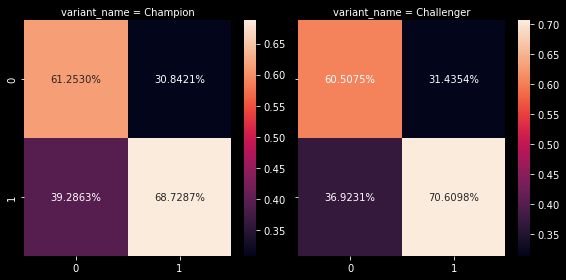

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def draw_heatmap(data, **kwargs):
    cf_matrix = confusion_matrix(data['is_helpful'], data['is_helpful_prediction'])
    print(data['variant_name'].unique()[0], cf_matrix)
    cf_percent = cf_matrix / cf_matrix.astype(np.float).sum(axis=1)
    sns.heatmap(cf_percent, annot=True, fmt=".4%")

fg = sns.FacetGrid(join_df, col='variant_name', height=4)
fg.map_dataframe(draw_heatmap)

### ROC_AUC 계산

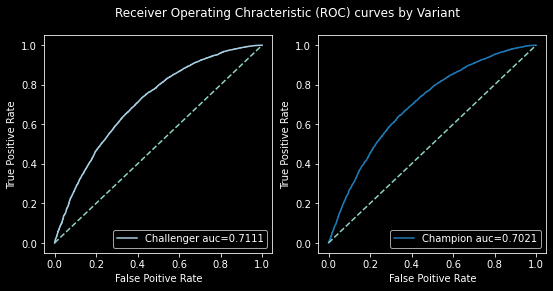

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("dark_background")



from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc(data):
    # Create horizontally stack plots (max is to to create at least 2 charts)
    fig, axs = plt.subplots(1, max(len(variant_names), 2), figsize=(9,4))
    fig.suptitle('Receiver Operating Chracteristic (ROC) curves by Variant')
    colors = sns.color_palette("Paired")
    # Plot the ROC curves by variant name
    for i, (variant_name, pred_df) in enumerate(data.groupby('variant_name')):        
        # Get true probability for ROC
        tp = pred_df.apply(lambda r: r['is_helpful_prob'] if r['is_helpful_prediction'] else 
                           1-r['is_helpful_prob'], axis=1)
        fpr, tpr, _ = roc_curve(pred_df['is_helpful'], tp)
        auc = roc_auc_score(pred_df['is_helpful'], tp)
        axs[i].plot(fpr,tpr,color=colors[i],label=f"{variant_name} auc={auc:.4f}")   
        axs[i].plot([0, 1], [0, 1], linestyle='--')
        axs[i].set_xlabel("False Poitive Rate")
        axs[i].set_ylabel("True Positive Rate")
        axs[i].legend(loc=4)
        
plot_roc(join_df)

# 3.  MAB A/B Testing Simulation 을 위한 심플 테스트



## 3.1. 변형 지표 저장을 위한 인라인 저장소 셋업

In [69]:
champion_seed_invocations=2
champion_seed_reward=1
challenger_seed_invocations=2
challenger_seed_reward=1


from api.variants_linline_db import VariantsInlineDB 
variant_db = VariantsInlineDB()

variant_record = variant_db.add_variant(variant_name="Champion", 
                            invocation=champion_seed_invocations, 
                            conversion=0, 
                            reward=champion_seed_reward, 
                            initial_variant_weight=1, 
                            verbose=False)

variant_record = variant_db.add_variant(variant_name="Challenger", 
                            invocation=challenger_seed_invocations, 
                            conversion=0, 
                            reward=challenger_seed_reward, 
                            initial_variant_weight=1, 
                            verbose=False)




print(json.dumps(variant_db.variant_dic, indent=2))

{
  "Champion": {
    "timestamp": "2022-04-17-08-30-33",
    "invocation": 2,
    "conversion": 0,
    "reward": 1,
    "initial_variant_weight": 1
  },
  "Challenger": {
    "timestamp": "2022-04-17-08-30-33",
    "invocation": 2,
    "conversion": 0,
    "reward": 1,
    "initial_variant_weight": 1
  }
}


## 3.2. api_predict() 동작 방식
- (1) 현재 variant_db 내용을 바탕으로  Tompson Sampling 을 통한 "대상 변형" 을 연산 후에 제공
- (2) "대상 변형" 으로 batch 사이즈 만큼을 앤드폰이트로 추론 함. (예: batch_size = 64)
- (3) 64개의 예측을 'is_helpful_prediction', 'is_helpful_prob' 로 정렬하여 Top 1 만 추출
    - is_helpful_prediction == True 가 존재하면 결론적으로 reward 는 1 
    - 아래의 reward 정의 참고
- (4) reward 가 1 이면 variant_db 에 업데이트 함.
    
    
#### Reward 정의 
reward 의 정의는 진실값읜 "is_helpful"가 예측 결과와 같으면 "1" 을 부여 하는 것으로 정의 
```
['is_helpful'] == ['is_helpful_prediction']
```


In [70]:
from api.utils import api_predict

In [71]:
batch_size = 1

input_batch = list(chunker(test_input, batch_size))
test_batch = list(chunker(test_df, batch_size))
print(len(input_batch), len(test_batch))

14226 14226


In [72]:
# batch_num 값으로 배치 수 조절 
batch_num = 2

batch_df = pd.concat(api_predict(i, endpoint_name, batch_size, input_batch[i],test_batch[i],variant_db, verbose=True) 
                     for i in range(len(input_batch)) if i <= batch_num ).reset_index(drop=True)



##################################

variant_name:  Challenger
prediction result: 
 [(True, 0.5536010265350342)]

Prediction with meta data


,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,False,True,0.553601,Challenger,TomsonSampling,0,1,0


Top predicton with meta data


,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,False,True,0.553601,Challenger,TomsonSampling,0,1,0



##################################

variant_name:  Challenger
prediction result: 
 [(True, 0.7482183575630188)]

Prediction with meta data


,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,True,True,0.748218,Challenger,TomsonSampling,1,1,1


Top predicton with meta data


,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,True,True,0.748218,Challenger,TomsonSampling,1,1,1


--> Reward and conversion are recoded in variant_db: 

##################################

variant_name:  Champion
prediction result: 
 [(True, 0.5175150036811829)]

Prediction with meta data


,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,True,True,0.517515,Champion,TomsonSampling,2,1,1


Top predicton with meta data


,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,True,True,0.517515,Champion,TomsonSampling,2,1,1


--> Reward and conversion are recoded in variant_db: 


## 3.3. 심플 테스트 결과 확인

In [73]:
batch_df 

,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,False,True,0.553601,Challenger,TomsonSampling,0,1,0
1,True,True,0.748218,Challenger,TomsonSampling,1,1,1
2,True,True,0.517515,Champion,TomsonSampling,2,1,1


In [74]:
print(json.dumps(variant_db.variant_dic, indent=2))

{
  "Challenger": {
    "timestamp": "2022-04-17-08-30-34",
    "invocation": 4,
    "conversion": 1,
    "reward": 2,
    "initial_variant_weight": 1
  },
  "Champion": {
    "timestamp": "2022-04-17-08-30-34",
    "invocation": 3,
    "conversion": 1,
    "reward": 2,
    "initial_variant_weight": 1
  }
}


# 4. 배치 A/B 테스트 시뮬레이션 추론 실행

## 4.1. 변형 지표 저장을 위한 인라인 저장소 셋업

### 변형의 수행 횟수, 리워드의 시작 값 설정

In [75]:
champion_seed_invocations=100
champion_seed_reward=50
challenger_seed_invocations=100
challenger_seed_reward=50

In [76]:

from api.variants_linline_db import VariantsInlineDB 
variant_db = VariantsInlineDB()

variant_record = variant_db.add_variant(variant_name="Champion", 
                            invocation=champion_seed_invocations, 
                            conversion=0, 
                            reward=champion_seed_reward, 
                            initial_variant_weight=1, 
                            verbose=False)

variant_record = variant_db.add_variant(variant_name="Challenger", 
                            invocation=challenger_seed_invocations, 
                            conversion=0, 
                            reward=challenger_seed_reward, 
                            initial_variant_weight=1, 
                            verbose=False)




print(json.dumps(variant_db.variant_dic, indent=2))

{
  "Champion": {
    "timestamp": "2022-04-17-08-30-34",
    "invocation": 100,
    "conversion": 0,
    "reward": 50,
    "initial_variant_weight": 1
  },
  "Challenger": {
    "timestamp": "2022-04-17-08-30-34",
    "invocation": 100,
    "conversion": 0,
    "reward": 50,
    "initial_variant_weight": 1
  }
}


## 4.2 MAB A/B 시뮬레이션 실행

In [77]:
batch_size = 64

input_batch = list(chunker(test_input, batch_size))
test_batch = list(chunker(test_df, batch_size))
print(len(input_batch), len(test_batch))

223 223


In [78]:
# batch_num 값으로 배치 수 조절 
batch_num = 200

batch_df = pd.concat(api_predict(i, endpoint_name, batch_size, input_batch[i],test_batch[i],variant_db) 
                     for i in range(len(input_batch)) if i <= batch_num ).reset_index(drop=True)
batch_df 

,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,True,True,0.761912,Challenger,TomsonSampling,0,1,1
1,True,True,0.808600,Challenger,TomsonSampling,1,1,1
2,False,True,0.801668,Challenger,TomsonSampling,2,1,0
3,False,True,0.798178,Challenger,TomsonSampling,3,1,0
4,False,True,0.757078,Champion,TomsonSampling,4,1,0
...,...,...,...,...,...,...,...,...
196,True,True,0.781755,Champion,TomsonSampling,196,1,1
197,True,True,0.767939,Champion,TomsonSampling,197,1,1
198,False,True,0.734083,Champion,TomsonSampling,198,1,0
199,True,True,0.689782,Champion,TomsonSampling,199,1,1


In [79]:
print(json.dumps(variant_db.variant_dic, indent=2))


{
  "Challenger": {
    "timestamp": "2022-04-17-08-30-36",
    "invocation": 116,
    "conversion": 12,
    "reward": 62,
    "initial_variant_weight": 1
  },
  "Champion": {
    "timestamp": "2022-04-17-08-30-38",
    "invocation": 285,
    "conversion": 141,
    "reward": 191,
    "initial_variant_weight": 1
  }
}


# 5. A/B 테스팅 시뮬레이션 분석


## 5.1. 각 변형의 리워드 가시화 

배치 결과를 변형 비율별로 그룹화하여 총 청구 횟수, 보상 및 계산된 비율을 요약합니다
- reward_rate = reward / invocation

In [80]:
variant_df = batch_df.groupby('variant_name').agg({
    'invocation': 'count', 
    'reward': 'sum'
})
variant_df['reward_rate'] = variant_df.apply(lambda r: r['reward']/r['invocation'], axis=1)
variant_df.sort_values('reward_rate', ascending=False)
variant_df

,invocation,reward,reward_rate
variant_name,,,
Challenger,16,12,0.750000
Champion,185,141,0.762162


## 5.2. 배치 수 진행에 따른 누적 리워드 가시화

일괄 호출에 대한 성능을 비교하기 위해 변형별 누적 호출 및 보상 추가

In [81]:
cum_df = batch_df.groupby(
    ['variant_name', 'batch'])[['invocation','reward']].sum().groupby(level=0).cumsum() #.reset_index()
cum_df['reward_rate'] = cum_df.apply(lambda r: 1.0 * r['reward'] / r['invocation'], axis=1)

Text(0.5, 1.0, 'Reward by Variant')

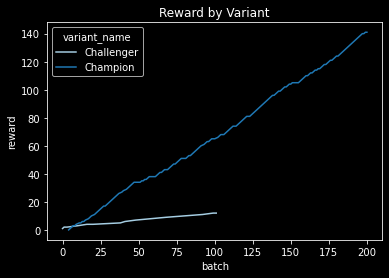

In [82]:
import seaborn as sns

sns.lineplot(data=cum_df, x="batch", y="reward", hue="variant_name", palette="Paired").set_title("Reward by Variant")

## 5.3. 배치 실행에 따른 보상 비율 (Reward Rate) 가시화


Text(0.5, 1.0, 'Reward Rate by Variant')

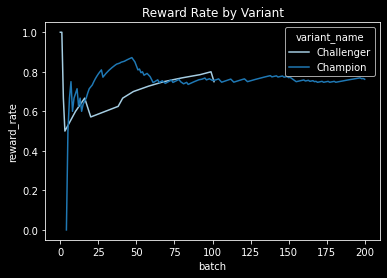

In [83]:
sns.lineplot(data=cum_df, x="batch", y="reward_rate", hue="variant_name", palette="Paired").set_title("Reward Rate by Variant")

## 5.4. 베타 분포 (Beta Distribution) 가시황



In [84]:
# Cut the results into 9 bucket, and plot on a 3x3 chart
bucket = 9
beta_df = cum_df.reset_index()
beta_df['bucket'] = pd.cut(beta_df['batch'], [0,2,5,10,20,50,100,200,500,1000], right=True)
beta_df = beta_df.groupby(['variant_name', 'bucket'])[['invocation', 'reward']].max()

Plot the beta distribution for each bucket

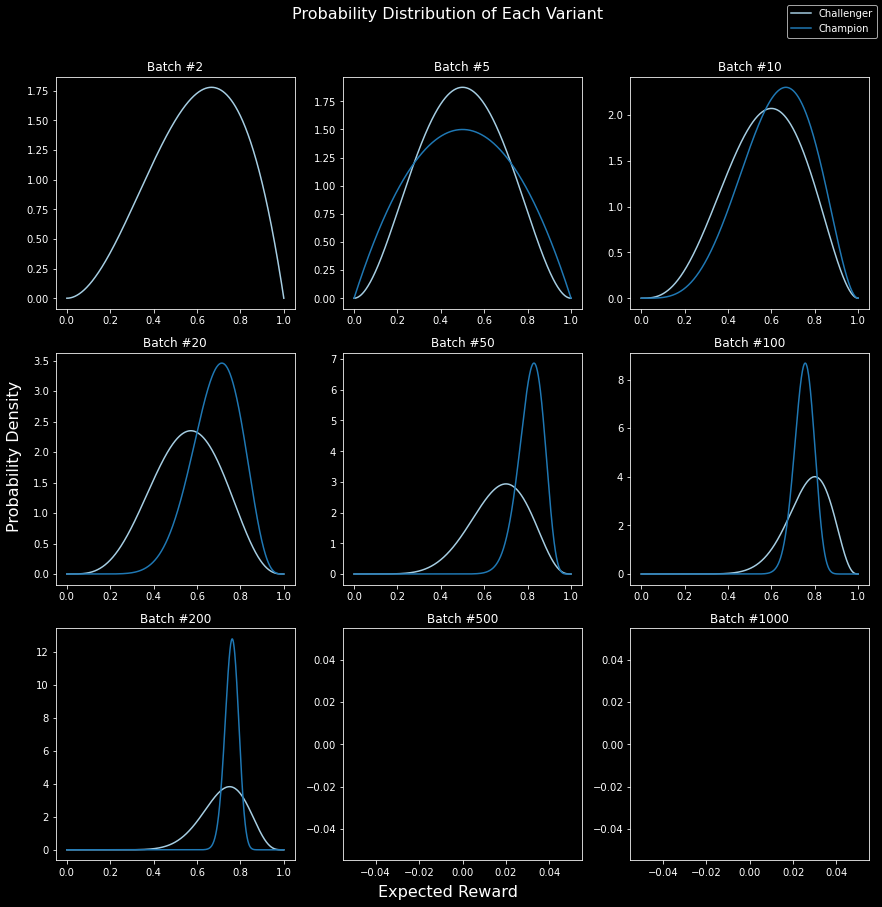

In [85]:
import numpy as np        
from scipy import stats
import matplotlib.pyplot as plt
colors = sns.color_palette("Paired")
plt.style.use("dark_background")

def plot_beta(beta_df):
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    fig.subplots_adjust(hspace = .5, wspace=.1)
    fig.suptitle('Probability Distribution of Each Variant', fontsize=16, y=1.02)
    fig.subplots_adjust(top=0.88)
    axs = axs.ravel()
    
    x = np.arange (0, 1.001, 0.001)
    for i, (b, bg) in enumerate(beta_df.groupby('bucket')):
        for j, (variant_name, vg) in enumerate(bg.groupby('variant_name')):
            v = vg.max()
            alpha, beta = 1+v['reward'], 1+v['invocation']-v['reward']
            axs[i].plot(x, stats.beta.pdf(x, alpha, beta), label=variant_name, color=colors[j])
        axs[i].set_title(f'Batch #{int(b.right)}')
        axs[i].grid(False)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.text(0.5, -.01, 'Expected Reward', ha='center', fontsize=16)
    fig.text(-.01, 0.5, 'Probability Density', va='center', fontsize=16, rotation='vertical')
    fig.tight_layout()
    plt.show()        
plot_beta(beta_df)

# 6. Winner 선출



In [86]:
variant_a, variant_b = variant_names[:2]
rate_a, num_a = variant_df.loc[variant_a]['reward_rate'], variant_df.loc[variant_a]['invocation']
rate_b, num_b = variant_df.loc[variant_b]['reward_rate'], variant_df.loc[variant_b]['invocation']
rate_diff = (rate_b - rate_a) / rate_a
rate_dir = f'{rate_diff:.2%} higher' if rate_diff > 0 else f'{-rate_diff:.2%} lower'
print(f"{variant_a}, \treward_rate: {round(rate_a,3)}, # of invocations : {int(num_a)}")
print(f"{variant_b}, \treward_rate: {round(rate_b,3)}, # of invocations : {int(num_b)}")
print("")
print(f'{variant_b} conversion rate ({rate_b:.2%}) is {rate_dir} than {variant_a} rate ({rate_a:.2%})')



Champion, 	reward_rate: 0.762, # of invocations : 185
Challenger, 	reward_rate: 0.75, # of invocations : 16

Challenger conversion rate (75.00%) is 1.60% lower than Champion rate (76.22%)


## 신뢰 점수 평가
정규 분포를 가정하고 가장 실적이 좋은 변형에 대한 신뢰 점수를 평가해 보겠습니다.

In [87]:
from scipy.stats import norm

def plot_distribution(variant_a, rate_a, num_a, variant_b, rate_b, num_b):
    # Calculate the standard error for a and b
    std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
    std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)
    z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
    p_value = norm().sf(z_score)
    conf = norm.cdf(z_score)
    # Plot distribution
    click_rate = np.linspace(0, 1.0, 200)
    prob_a = norm(rate_a, std_a).pdf(click_rate)
    prob_b = norm(rate_b, std_b).pdf(click_rate)    
    plt.plot(click_rate, prob_a, label=variant_a, color=colors[0])
    plt.plot(click_rate, prob_b, label=variant_b, color=colors[1])
    plt.legend(frameon=True)
    plt.xlabel("Conversion rate"); plt.ylabel("Probability");
    plt.title(f"zscore is {z_score:0.3f}, with p-value {p_value:0.3f}")
    return z_score, p_value, conf

Confidene score: 0.457


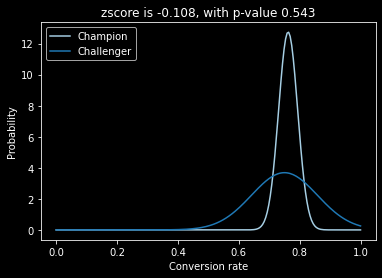

In [88]:

# Plot distribution and get confidence interval
z_score, p_value, conf = plot_distribution(variant_a, rate_a, num_a, variant_b, rate_b, num_b)

if rate_diff > 0 and conf > 0.95:
    print(f'The result is statisticially significant')
print(f"Confidene score: {round(conf,3)}")

# 7. 엔드포인트 삭제

- <font color="red" size="5">작업이 완료시에 주석을 해제하시고 **반드시** 실행하여 엔드포인트를 삭제 해주세요. 안그러면 과다한 요금이 청구 됩니다.</font>

In [89]:
# from api.utils import delete_endpoint
# import boto3
# boto3_client = boto3.client('sagemaker')
# delete_endpoint(boto3_client, endpoint_name, is_del_model=True )